# 09. 객체탐지 실습
---





```
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import os, glob, cv2

from google.colab.patches import cv2_imshow
```

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import os, glob, cv2

from google.colab.patches import cv2_imshow

## 과제: 마스크 탐지
<p align='center'>
<img src=https://github.com/kairess/mask-detection/raw/master/imgs/result.png   width=400>
</p>


---
### 모델1: 탐지
---

* 마스크탐지: 
  1. 이미지를 모델에 넣으면
  1. 이미지에서 얼굴 영역만 찾고
  1. 크롭된 영역만 분류 모델에 넘기기 


In [ ]:
! git clone https://github.com/yebiny/Face-detection-for-DSM.git

Cloning into 'Face-detection-for-DSM'...
remote: Enumerating objects: 52, done.
remote: Counting objects: 100% (52/52), done.
remote: Compressing objects: 100% (50/50), done.
remote: Total 52 (delta 9), reused 0 (delta 0), pack-reused 0
Unpacking objects: 100% (52/52), done.


In [ ]:
model_dir = '/content/Face-detection-for-DSM/models'
facenet = cv2.dnn.readNet(model_dir + '/deploy.prototxt',
                          model_dir + '/res10_300x300_ssd_iter_140000.caffemodel')

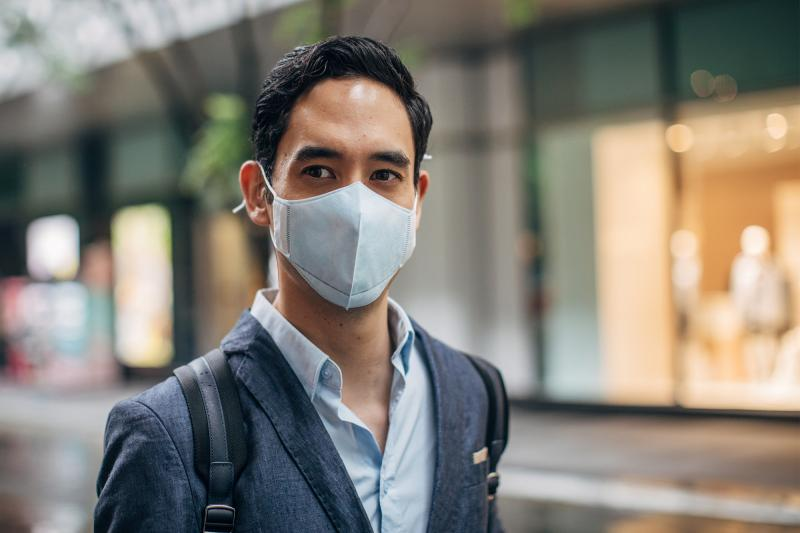

In [ ]:
img_path = 'person_mask.jpg'
img = cv2.imread(img_path)
cv2_imshow(img)
h, w, _ = img.shape

In [ ]:
img_blob = cv2.dnn.blobFromImage(img, scalefactor=1.0, size=(300,300))
facenet.setInput(img_blob)
preds = facenet.forward()[0][0]
print(preds.shape)

(200, 7)


0.65869826 274 70 415 314


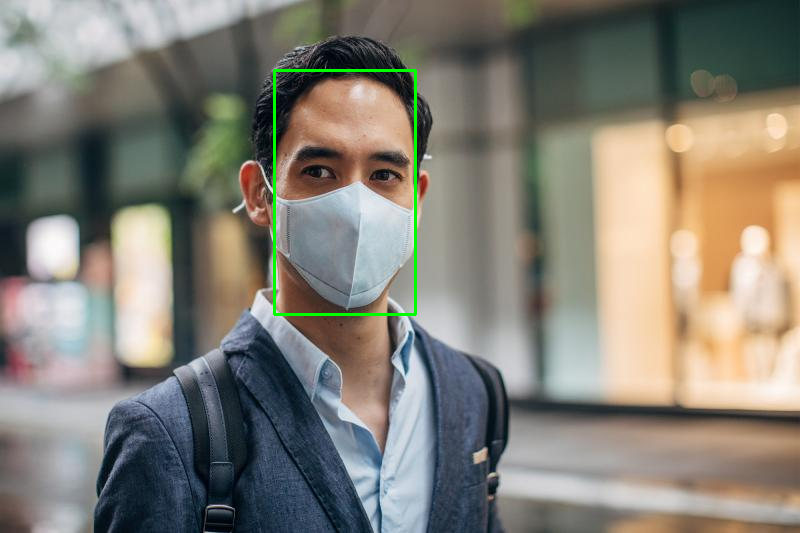

In [ ]:
thres = 0.5
for i in range(len(preds)):
  conf = preds[i, 2]
  if conf < thres:
    continue
  x1 = int(preds[i, 3] * w)
  y1 = int(preds[i, 4] * h)
  x2 = int(preds[i, 5] * w)
  y2 = int(preds[i, 6] * h)
  cv2.rectangle(img, (x1, y1), (x2, y2), (0,255,0), 2)
  print(conf, x1,y1,x2,y2)

cv2_imshow(img)

---
### 모델2: 분류
---

1. 탐지를 통해 얼굴사진이 들어오면
1. 분류모델을 통해 마스크/하품  판단하기

분류모델은 만들어지지 않았기 때문에 직접 만들도록 합니다.

#### **데이터준비**


* 마스크 데이터 로드

```
! git clone https://github.com/prajnasb/observations.git
```

* 위치: `observations/experiements/data/`

In [ ]:
! git clone https://github.com/prajnasb/observations.git

Cloning into 'observations'...
remote: Enumerating objects: 1638, done.
remote: Total 1638 (delta 0), reused 0 (delta 0), pack-reused 1638
Receiving objects: 100% (1638/1638), 75.94 MiB | 31.80 MiB/s, done.
Resolving deltas: 100% (19/19), done.


In [ ]:
! ls observations/experiements/data

with_mask  without_mask


In [ ]:
data_dir = 'observations/experiements/data'

for class_name in ['with_mask', 'without_mask']:
  # 각 폴더의 파일들을 확인
  f_list = glob.glob('%s/%s/*jpg'%(data_dir, class_name))
  print(class_name)
  print(len(f_list))

with_mask
690
without_mask
686


(-0.5, 458.5, 445.5, -0.5)

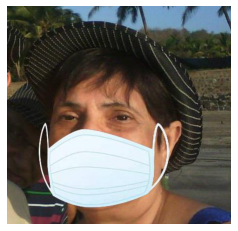

In [ ]:
class_name = 'with_mask'
f_list = glob.glob('%s/%s/*jpg'%(data_dir, class_name))
img = plt.imread(f_list[5])
plt.imshow(img)
plt.axis('off')

In [ ]:
from tensorflow.keras import preprocessing

IMG_SIZE = 160
BATCH_SIZE = 16
N_CLASS = 5

In [ ]:
train_ds = preprocessing.image_dataset_from_directory( data_dir,  # 데이터 폴더 경로 
                                                       subset="training",
                                                       validation_split=0.2,
                                                       image_size=(IMG_SIZE, IMG_SIZE),
                                                       batch_size=BATCH_SIZE,
                                                       seed=123 )

valid_ds = preprocessing.image_dataset_from_directory( data_dir,  # 데이터 폴더 경로 
                                                       subset="validation",
                                                       validation_split=0.2,
                                                       image_size=(IMG_SIZE, IMG_SIZE),
                                                       batch_size=BATCH_SIZE,
                                                       seed=123 )

Found 1376 files belonging to 2 classes.
Using 1101 files for training.
Found 1376 files belonging to 2 classes.
Using 275 files for validation.


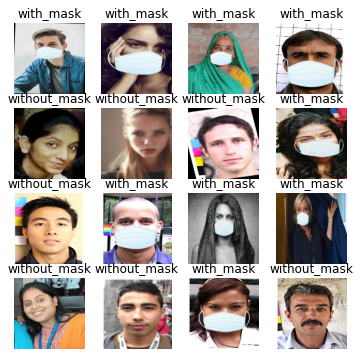

In [ ]:
plt.figure(figsize=(6,6))
for imgs, labels in train_ds.take(1):
  for i, (img, label) in enumerate(zip(imgs, labels)):
    plt.subplot(4,4, i+1)
    plt.imshow(img.numpy().astype("uint8"))
    plt.title(train_ds.class_names[label])
    plt.axis('off')

#### **모델 학습**

In [ ]:
from tensorflow.keras import layers, models, losses, optimizers
aug = tf.keras.Sequential([
      layers.experimental.preprocessing.RandomFlip(),
      layers.experimental.preprocessing.RandomRotation(0.2)
])

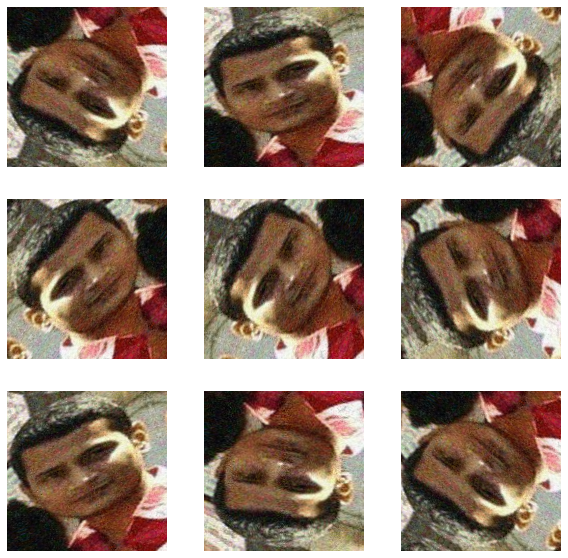

In [ ]:
for image, _ in train_ds.take(1):
  plt.figure(figsize=(10, 10))
  first_image = image[0]
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    aug_image = aug(tf.expand_dims(first_image, 0))
    plt.imshow(aug_image[0] / 255)
    plt.axis('off')

In [ ]:
from tensorflow.keras import applications

base_model = tf.keras.applications.EfficientNetB1(input_shape=(IMG_SIZE,IMG_SIZE,3),
                                                  include_top=False,
                                                  weights='imagenet')
base_model.summary()

27033600/27018416 [==============================] - 0s 0us/step
Model: "efficientnetb1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 160, 160, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling (Rescaling)          (None, 160, 160, 3)  0           ['input_1[0][0]']                
                                                                                                  
 normalization (Normalization)  (None, 160, 160, 3)  7           ['rescaling[0][0]']              
                                                                                                  
 stem_conv_pad (Zero

In [ ]:
base_model.trainable = False

x = layers.Input(shape=(160, 160, 3))
z = aug(x)  # 데이터 증강
z = applications.efficientnet.preprocess_input(z)   # efficientnet에 맞는 프로세싱
z = base_model(z, training=False)
z = layers.GlobalAveragePooling2D()(z)
# z = layers.Flatten()
z = layers.Dropout(0.2)(z)
y = layers.Dense(2, activation='softmax')(z)        # output 클래스 개수에 맞게

transfer = models.Model(x, y)
transfer.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 160, 160, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 160, 160, 3)       0         
                                                                 
 efficientnetb1 (Functional)  (None, 5, 5, 1280)       6575239   
                                                                 
 global_average_pooling2d (G  (None, 1280)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dropout (Dropout)           (None, 1280)              0         
                                                                 
 dense (Dense)               (None, 2)                 2562      
                                                             

In [ ]:
from tensorflow.keras import callbacks

reduce_lr = callbacks.ReduceLROnPlateau(monitor='val_loss',
                                        factor = 0.2,
                                        patience = 3,
                                        min_lr = 0.000001)
ckp = callbacks.ModelCheckpoint('model.h5', save_best_only=True)

In [ ]:
transfer.compile(loss = losses.SparseCategoricalCrossentropy(),
                 optimizer = optimizers.RMSprop(learning_rate=0.0001),
                 metrics = ['acc'])

In [ ]:
history_transfer = transfer.fit(train_ds,
                                validation_data = valid_ds,
                                epochs = 10,
                                callbacks = [reduce_lr, ckp])

Epoch 1/10
69/69 [==============================] - ETA: 0s - loss: 0.6755 - acc: 0.6122

/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


69/69 [==============================] - 40s 171ms/step - loss: 0.6755 - acc: 0.6122 - val_loss: 0.4145 - val_acc: 0.8873 - lr: 1.0000e-04
Epoch 2/10
69/69 [==============================] - 8s 117ms/step - loss: 0.5031 - acc: 0.7757 - val_loss: 0.2767 - val_acc: 0.9564 - lr: 1.0000e-04
Epoch 3/10
69/69 [==============================] - 8s 117ms/step - loss: 0.3732 - acc: 0.8883 - val_loss: 0.1959 - val_acc: 0.9782 - lr: 1.0000e-04
Epoch 4/10
69/69 [==============================] - 8s 115ms/step - loss: 0.2910 - acc: 0.9328 - val_loss: 0.1445 - val_acc: 0.9855 - lr: 1.0000e-04
Epoch 5/10
69/69 [==============================] - 8s 119ms/step - loss: 0.2269 - acc: 0.9573 - val_loss: 0.1097 - val_acc: 0.9927 - lr: 1.0000e-04
Epoch 6/10
69/69 [==============================] - 8s 118ms/step - loss: 0.1848 - acc: 0.9655 - val_loss: 0.0879 - val_acc: 0.9964 - lr: 1.0000e-04
Epoch 7/10
69/69 [==============================] - 8s 116ms/step - loss: 0.1674 - acc: 0.9655 - val_loss: 0.0712 - 

In [ ]:
transfer.evaluate(valid_ds)

18/18 [==============================] - 2s 77ms/step - loss: 0.0455 - acc: 0.9964


[0.045491743832826614, 0.996363639831543]

(16, 160, 160, 3) (16,)
(16, 2)
[0 1 1 0 1 0 1 0 0 0 0 0 0 0 1 1]
[0 1 1 0 1 0 1 0 0 0 0 0 0 0 1 1]


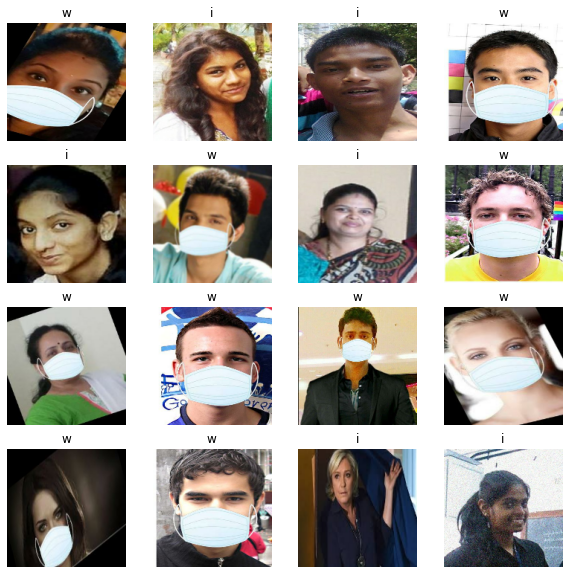

In [ ]:
imgs, labels = valid_ds.as_numpy_iterator().next()
print(imgs.shape, labels.shape)
preds = transfer.predict_on_batch(imgs)
print(preds.shape)
preds = np.argmax(preds, axis=1)
print(preds)
print(labels)
plt.figure(figsize=(10,10))
for i in range(16):
  plt.subplot(4,4,i+1)
  plt.imshow(imgs[i].astype("uint8"))
  # plt.title(valid_dataset.class_name[preds[i]])
  plt.title(class_name[preds[i]])
  plt.axis('off')

---
### 모델3: 탐지 전체 플로우
---

이미지 -> ( **탐지모델** ) -> 얼굴 크롭된 이미지 -> ( **분류모델** ) -> visualization 된 이미지 

In [ ]:
! git clone https://github.com/yebiny/Face-detection-for-DSM.git

fatal: destination path 'Face-detection-for-DSM' already exists and is not an empty directory.


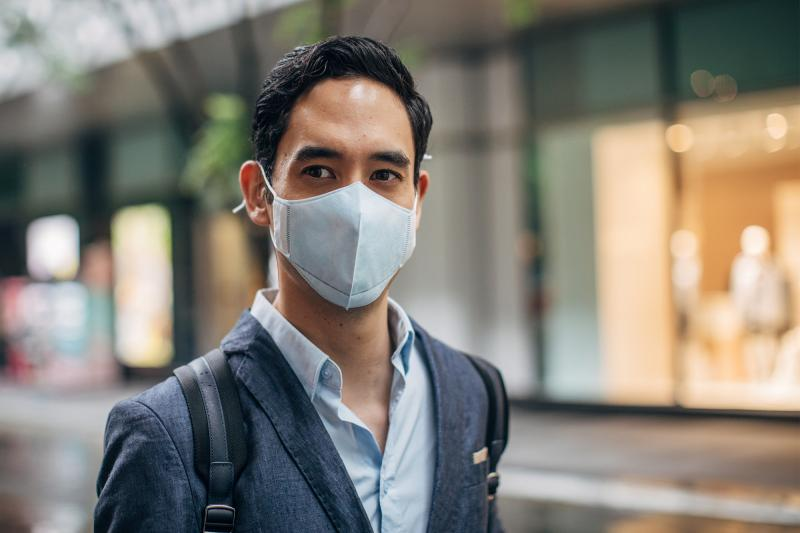

In [ ]:
img_path = 'person_mask.jpg'
img = cv2.imread(img_path)
cv2_imshow(img)
h, w, _ = img.shape

In [ ]:
model_dir = '/content/Face-detection-for-DSM/models'
facenet = cv2.dnn.readNet(model_dir + '/deploy.prototxt',
                          model_dir + '/res10_300x300_ssd_iter_140000.caffemodel')

# pass the blob through the network and obtain the face detections
print("[INFO] computing face detections...")
# construct a blob from the image
blob = cv2.dnn.blobFromImage(img, 1.0, (300, 300), (104.0, 177.0, 123.0))
facenet.setInput(blob)
detections = facenet.forward()

faces=[]
for i in range(detections.shape[2]):
  conf = detections[0,0,i,2]
  if conf <0.5:
    continue
  x1 = int(detections[0,0,i,3]*w)
  y1 = int(detections[0,0,i,4]*h)
  x2 = int(detections[0,0,i,5]*w)
  y2 = int(detections[0,0,i,6]*h)

  face = img[y1:y2, x1:x2]
  faces.append(face)
  print(face.shape,type(face))

[INFO] computing face detections...
(249, 141, 3) <class 'numpy.ndarray'>


(1, 160, 160, 3)


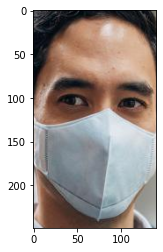

numpy.ndarray

In [ ]:
from tensorflow.keras.preprocessing.image import img_to_array
# from tensorflow.keras.applications.efficientnet import preprocess_input

for face in faces:
  # img = tf.image.resize(images=face, size=[160, 160])
  # img = tf.expand_dims(img, axis=0)

  # # predict
  # (mask, withoutMask) = transfer.predict(img)[0]
  # print( mask, withoutMask)

  # # visualize
  # label = "Mask" if mask > withoutMask else "No Mask"
  # color = (0, 255, 0) if label == "Mask" else (0, 0, 255)
  # label = "{}: {:.2f}%".format(label, max(mask, withoutMask) * 100)

  # cv2.putText(img, label, (x1, y2 - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.45, color, 2)
  # cv2.rectangle(img, (x1, y1), (x2, y2), color, 2)
  # cv2_imshow(img)

  face = cv2.resize(face, (160,160))
  face = img_to_array(face)
  # face = preprocess_input(face)
  face = np.expand_dims(face, axis=0)
  print(face.shape)
  plt.imshow(cv2.cvtColor(faces[0], cv2.COLOR_BGR2RGB))
plt.show()
type(face)

[0]


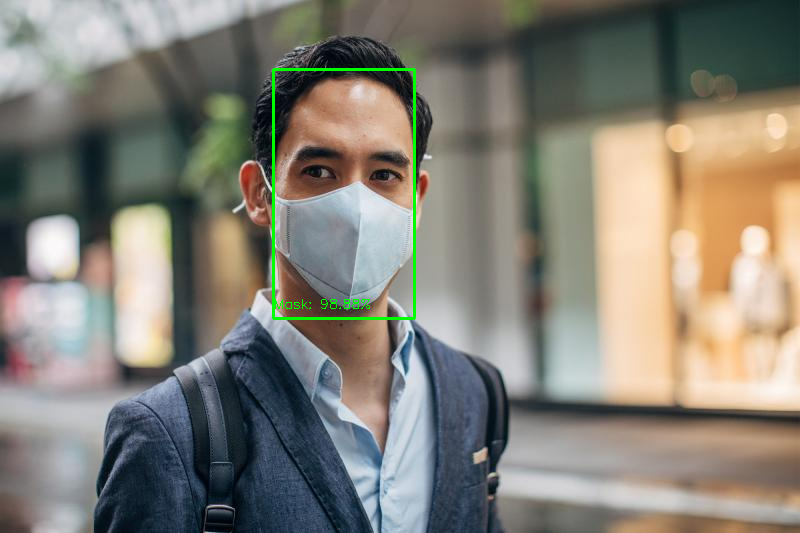

In [ ]:
img_arr = preprocessing.image.img_to_array(img)
img_arr = tf.expand_dims(img_arr, 0)  # (1, 160, 160, 3)
pred = transfer.predict_on_batch(img_arr)
pred = np.argmax(pred, axis=1)
print(pred)

# plt.title(class_name[pred[0]])
# plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
# plt.axis('off')

label = "Mask" if class_name[pred[0]] == 'w' else "No Mask"
color = (0, 255, 0) if label == "Mask" else (0, 0, 255)
label = "{}: {:.2f}%".format(label, max(mask, withoutMask) * 100)

cv2.putText(img, label, (x1, y2 - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.45, color, 1)
cv2.rectangle(img, (x1, y1), (x2, y2), color, 2)
cv2_imshow(img)

In [ ]:
transfer.save('mask.h5')

/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
